# Getting started
* The algorithm consists of three parts: the first is the __table detection and cell recognition with Open CV__, the second the __thorough allocation of the cells__ to the proper row and column and the third part is the extraction of each allocated cell through __Optical Character Recognition (OCR) with pytesseract__.
* First, we need the input data, which is in my case a __screenshot in png-format__. The goal is to have a dataframe and excel-file with the identical tabular structure, where each cell can be edited and used for further analysis.


# Import necessary files
For more information on the libraries:  
[cv2](https://opencv.org/)  
[pytesseract](https://pypi.org/project/pytesseract/)

In [49]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

##### The first step is to read in your file from the proper path, using thresholding to convert the input image to a binary image and inverting it to get a black background and white lines and fonts.

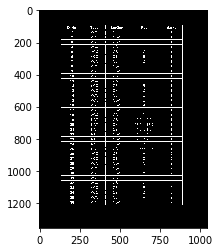

In [50]:
#read your file
file=r'test/CS1_key1.jpg'
img = cv2.imread(file,0)
img.shape
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('test/CS1_key1_inv.jpg',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

##### The next step is to define a kernel to detect rectangular boxes, and followingly the tabular structure. First, we define the length of the kernel and following the vertical and horizontal kernels to detect later on all vertical lines and all horizontal lines.

In [51]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

##### The next step is the detection of the vertical lines.

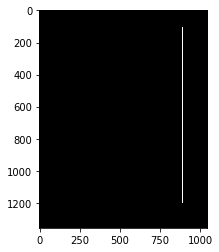

In [52]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("test/CS1_key1_vertical.jpg",vertical_lines)
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

##### And now the same for all horizontal lines.

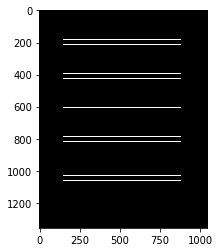

In [53]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("test/CS1_key1_horizontal.jpg",horizontal_lines)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

##### We combine the horizontal and vertical lines to a third image, by weighting both with 0.5. The aim is to get a clear tabular structure to detect each cell.

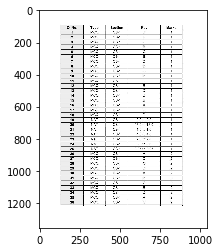

In [54]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("test/CS1_key1_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [55]:
## My edit

cv2.imwrite("test/CS1_key1_detect_lines.jpg",bitnot)

True

##### After having the tabular structure we use the findContours function to detect the contours. This helps us to retrieve the exact coordinates of each box.

In [56]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

##### The following function is necessary to get a sequence of the contours and to sort them from top-to-bottom [1](https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/).

In [57]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")


# How to retrieve the cells position
##### The further steps are necessary to define the right location, which means proper column and row, of each cell. First, we need to retrieve the height for each cell and store it in the list heights. Then we take the mean from the heights.

In [58]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

##### Next we retrieve the position, width and height of each contour and store it in the box list. Then we draw rectangles around all our boxes and plot the image. In my case I only did it for boxes smaller then a width of 1000 px and a height of 500 px to neglect rectangles which might be no cells, e.g. the table as a whole. These two values depend on your image size, so in case your image is a lot smaller or bigger you need to adjust both.

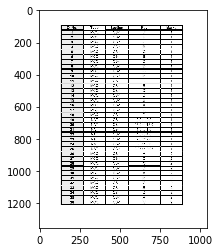

In [59]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

##### Now as we have every cell, its location, height and width we need to get the right location within the table. Therefore, we need to know in which row and which column it is located. As long as a box does not differ more than its own (height + mean/2) the box is in the same row. As soon as the height difference is higher than the current (height + mean/2) , we know that a new row starts. Columns are logically arranged from left to right.

In [60]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[753, 1182, 135, 27], [554, 1182, 196, 27], [415, 1182, 135, 27], [276, 1182, 136, 27], [138, 1182, 135, 27]]
[[[753, 96, 135, 26], [554, 96, 196, 26], [415, 96, 135, 26], [276, 96, 136, 27], [138, 96, 135, 26]], [[753, 126, 135, 27], [554, 126, 196, 27], [415, 126, 135, 27], [276, 126, 136, 27], [138, 126, 135, 27]], [[753, 156, 135, 27], [554, 156, 196, 27], [415, 156, 135, 27], [276, 156, 136, 27], [138, 156, 135, 27]], [[753, 186, 135, 27], [554, 186, 196, 27], [415, 186, 135, 27], [276, 186, 136, 27], [138, 186, 135, 27]], [[753, 217, 135, 26], [554, 217, 196, 26], [415, 217, 135, 26], [276, 217, 136, 26], [138, 217, 135, 26]], [[753, 247, 135, 26], [554, 247, 196, 26], [415, 247, 135, 26], [276, 247, 136, 26], [138, 247, 135, 26]], [[753, 277, 135, 27], [554, 277, 196, 27], [415, 277, 135, 27], [276, 277, 136, 27], [138, 277, 135, 26]], [[753, 307, 135, 27], [554, 307, 196, 27], [415, 307, 135, 27], [276, 307, 136, 27], [138, 307, 135, 27]], [[753, 337, 135, 27], [554, 337, 196,

##### Next we calculate the maximum number of columns (meaning cells) to understand how many columns our final dataframe/table will have.

In [61]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

##### After having the maximum number of cells we store the midpoint of each column in a list, create an array and sort the values.

In [62]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

##### At this point, we have all boxes and their values, but as you might see in the output of your row list the values are not always sorted in the right order. That’s what we do next regarding the distance to the columns center. The proper sequence we store in the list finalboxes.

In [63]:
# Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


# Let’s extract the values
##### In the next step we make use of our list finalboxes. We take every image-based box, prepare it for Optical Character Recognition by dilating and eroding it and let pytesseract recognize the containing strings. The loop runs over every cell and stores the value in the outer list.


In [64]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)


##### The last step is the conversion of the list to a dataframe and storing it into an excel-file.

In [65]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
dataframe
# data = dataframe.style.set_properties(align="left")
# Converting it in a excel-file
# data.to_excel()

,0,1,2,3,4
0,Q. No.,Type,Section,Key,Marks
1,,MCQ,CS-1,,
2,,MCQ,CS-1,,
3,,MCQ,CS-1,,
4,,MCQ,CS-1,,
5,,MCQ,CS-1,,
6,,MCQ,CS-1,,
7,,MCQ,CS-1,,
8,,MCQ,CS-1,,
9,,MCQ,CS-1,,


__That’s it!__ Your table should now be stored in a dataframe and in an excel-file and can be used for Nature Language Processing, for further analysis via statistics or just for editing it. This works for tables with a clear and simple structure. In case your table has an extraordinary structure, in the sense that many cells are combined, that the cells size varies strongly or that many colours are used, the algorithm may has to be adopted. Furthermore OCR (pytesseract) is nearly perfect in recognizing computer fonts. However, if you have tables containing handwritten input, the results may vary.
If you use it for your own table(s), let me know how it worked.

## A big thanks to Hucker Marius, whose work inspired this small venture 

link to the article [here](https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec)